In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
plt.style.use("default")

In [5]:
train_clf = pd.read_csv(r"C:\Users\sffra\Downloads\BSE 2025-2026\cml_final\data\raw\MIMIC III dataset HEF\mimic_train_HEF.csv")  # adjust path
test_clf  = pd.read_csv(r"C:\Users\sffra\Downloads\BSE 2025-2026\cml_final\data\raw\MIMIC III dataset HEF\mimic_test_HEF.csv") 

train_clf.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


Cleaning

In [6]:
id_cols = ["icustay_id", "hadm_id", "subject_id"]

# Target vector (label)
y_train = train_clf["HOSPITAL_EXPIRE_FLAG"].copy()

# Keep ICU stay IDs for later (for final predictions)
train_ids = train_clf["icustay_id"].copy()  
test_ids  = test_clf["icustay_id"].copy()

# Columns that should NOT be used as features
leakage_cols = ["DEATHTIME", "DISCHTIME", "DOD", "LOS", "HOSPITAL_EXPIRE_FLAG"]

# For safety, only drop columns that actually exist in the dataframe
cols_to_drop_train = [c for c in (id_cols + leakage_cols) if c in train_clf.columns]
cols_to_drop_test  = [c for c in id_cols if c in test_clf.columns]

# New, cleaned feature dataframes (raw features before any encoding/imputation)
X_train_raw = train_clf.drop(columns=cols_to_drop_train).copy()
X_test_raw  = test_clf.drop(columns=cols_to_drop_test).copy()


In [7]:
import numpy as np
from sklearn.impute import SimpleImputer

num_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()

num_imputer = SimpleImputer(strategy="median")

# 3. Fit on TRAIN numeric data only
num_imputer.fit(X_train_raw[num_cols])

# 4. Transform both TRAIN and TEST numeric data
X_train_num = num_imputer.transform(X_train_raw[num_cols])
X_test_num  = num_imputer.transform(X_test_raw[num_cols])

# 5. Put them back into DataFrames if you want to keep column names
X_train_imputed = X_train_raw.copy()
X_test_imputed  = X_test_raw.copy()

X_train_imputed[num_cols] = X_train_num
X_test_imputed[num_cols]  = X_test_num

In [8]:
cat_cols = X_train_imputed.select_dtypes(exclude=[np.number]).columns.tolist()

# 1. Compute the most frequent MARITAL_STATUS *from the training data only*
marital_mode = X_train_imputed["MARITAL_STATUS"].mode()[0]
print("Most frequent MARITAL_STATUS in train:", marital_mode)

# 2. Fill missing MARITAL_STATUS in TRAIN using that value
X_train_imputed["MARITAL_STATUS"] = (
    X_train_imputed["MARITAL_STATUS"].fillna(marital_mode)
)

# 3. Fill missing MARITAL_STATUS in TEST using the SAME value
X_test_imputed["MARITAL_STATUS"] = (
    X_test_imputed["MARITAL_STATUS"].fillna(marital_mode)
)

# 4. Sanity check: no missing values left in that column
print("Train MARITAL_STATUS NaNs:", X_train_imputed["MARITAL_STATUS"].isna().sum())
print("Test MARITAL_STATUS NaNs:",  X_test_imputed["MARITAL_STATUS"].isna().sum())


Most frequent MARITAL_STATUS in train: MARRIED
Train MARITAL_STATUS NaNs: 0
Test MARITAL_STATUS NaNs: 0


## 4. Feature engineering (v2)

In this version we create additional features from the raw columns
(e.g. age at admission, time-of-day information, simple derived
variables) **before** applying the preprocessing pipeline.
All engineered features are computed row-wise without using the
target or information from other patients to avoid data leakage.


In [9]:
import numpy as np

def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add simple row-level numeric features:
    - Ranges (max - min) for vitals
    - Abnormal vital flags (0/1)
    - instability_count = sum of selected flags
    """
    df = df.copy()

    # -----------------------------
    # 1. RANGES (instability of vitals)
    # -----------------------------
    df["HR_range"]        = df["HeartRate_Max"]  - df["HeartRate_Min"]
    df["SysBP_range"]     = df["SysBP_Max"]      - df["SysBP_Min"]
    df["DiasBP_range"]    = df["DiasBP_Max"]     - df["DiasBP_Min"]
    df["MeanBP_range"]    = df["MeanBP_Max"]     - df["MeanBP_Min"]
    df["RespRate_range"]  = df["RespRate_Max"]   - df["RespRate_Min"]
    df["TempC_range"]     = df["TempC_Max"]      - df["TempC_Min"]
    df["SpO2_range"]      = df["SpO2_Max"]       - df["SpO2_Min"]
    df["Glucose_range"]   = df["Glucose_Max"]    - df["Glucose_Min"]

    # -----------------------------
    # 2. ABNORMAL VITAL FLAGS (0/1)
    #    Simple, clinically sensible thresholds
    # -----------------------------

    # Cardiovascular
    df["tachy_flag"]       = (df["HeartRate_Max"] >= 120).astype(int)
    df["hypotension_flag"] = (
        (df["SysBP_Min"] < 90) | (df["MeanBP_Min"] < 65)
    ).astype(int)

    # Respiratory
    df["tachypnea_flag"]   = (df["RespRate_Max"] >= 30).astype(int)

    # Temperature
    df["fever_flag"]       = (df["TempC_Max"] >= 38.0).astype(int)

    # Oxygenation
    df["hypoxia_flag"]     = (df["SpO2_Min"] < 92).astype(int)

    # Glucose
    df["hyperglycemia_flag"] = (df["Glucose_Max"] >= 200).astype(int)

    # (You can add more flags later if you like, e.g. brady, hypothermia, hypoglycemia, etc.)

    # -----------------------------
    # 3. INSTABILITY COUNT
    #    How many of the above flags are abnormal?
    # -----------------------------
    instability_flags = [
        "tachy_flag",
        "hypotension_flag",
        "tachypnea_flag",
        "fever_flag",
        "hypoxia_flag",
        "hyperglycemia_flag",
    ]
    df["instability_count"] = df[instability_flags].sum(axis=1)

    return df


# Apply feature engineering to TRAIN and TEST
X_train_raw = add_engineered_features(X_train_raw)
X_test_raw  = add_engineered_features(X_test_raw)

print("X_train_raw shape after FE:", X_train_raw.shape)
print("X_test_raw shape after FE:", X_test_raw.shape)


X_train_raw shape after FE: (20885, 51)
X_test_raw shape after FE: (5221, 51)


## 4. Preprocessing pipeline & train/validation split (classification)

In this section we:

- Use the raw feature matrix `X_train_raw`
- Define numerical and categorical feature groups.
- Build a scikit-learn `ColumnTransformer` that:
  - imputes missing values (median for numeric, most frequent for categorical),
  - scales numeric features for linear models,
  - one-hot encodes categorical features.
- Create a stratified train/validation split on the classification target `HOSPITAL_EXPIRE_FLAG`.

This preprocessing will be shared by all models in this notebook.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# -----------------------------
# 1. Define feature matrix and target for CLASSIFICATION
# -----------------------------

# Use the raw feature matrix AFTER dropping IDs + leakage
X = X_train_raw.copy()
y = y_train.copy()   # HOSPITAL_EXPIRE_FLAG from earlier cell

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("Positive rate:", y.mean().round(3))

# -----------------------------
# 2. Ensure numeric / categorical feature lists
# -----------------------------

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features ({len(num_cols)}):", num_cols[:10], "...")
print(f"Categorical features ({len(cat_cols)}):", cat_cols)

# -----------------------------
# 3. Define preprocessing for numeric & categorical columns
# -----------------------------

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# -----------------------------
# 4. Create train/validation split (stratified)
# -----------------------------

X_train, X_valid, y_train_split, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Train size:", X_train.shape[0], "Validation size:", X_valid.shape[0])
print("Train positive rate:", y_train_split.mean().round(3))
print("Valid positive rate:", y_valid.mean().round(3))


Feature matrix shape: (20885, 51)
Target shape: (20885,)
Positive rate: 0.112
Numeric features (40): ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min'] ...
Categorical features (11): ['GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 'FIRST_CAREUNIT']
Train size: 16708 Validation size: 4177
Train positive rate: 0.112
Valid positive rate: 0.112


## 5. Baseline model – Logistic Regression (no feature engineering)

In this section we:

- Wrap the `preprocessor` in a scikit-learn `Pipeline` with a `LogisticRegression` classifier.
- Fit the model on the training split.
- Evaluate performance on the validation split using:
  - ROC AUC
  - Accuracy
  - Confusion matrix
  - Classification report (precision/recall/F1)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# -----------------------------
# 1. Build pipeline: preprocessing + logistic regression
# -----------------------------

log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",  # handle class imbalance
            solver="lbfgs"
        )),
    ]
)

# -----------------------------
# 2. Fit on the training split
# -----------------------------

log_reg_clf.fit(X_train, y_train_split)

# -----------------------------
# 3. Predict on the validation split
# -----------------------------

# Probabilities for the positive class (HOSPITAL_EXPIRE_FLAG = 1)
y_valid_proba = log_reg_clf.predict_proba(X_valid)[:, 1]

# Default 0.5 threshold for class labels
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

# -----------------------------
# 4. Compute and print metrics
# -----------------------------

roc_auc = roc_auc_score(y_valid, y_valid_proba)
acc = accuracy_score(y_valid, y_valid_pred)
cm = confusion_matrix(y_valid, y_valid_pred)

print(f"Validation ROC AUC: {roc_auc:.3f}")
print(f"Validation accuracy: {acc:.3f}")
print("Confusion matrix (rows: true, cols: pred):")
print(cm)
print("\nClassification report:")
print(classification_report(y_valid, y_valid_pred, digits=3))


Validation ROC AUC: 0.868
Validation accuracy: 0.890
Confusion matrix (rows: true, cols: pred):
[[3439  269]
 [ 192  277]]

Classification report:
              precision    recall  f1-score   support

           0      0.947     0.927     0.937      3708
           1      0.507     0.591     0.546       469

    accuracy                          0.890      4177
   macro avg      0.727     0.759     0.741      4177
weighted avg      0.898     0.890     0.893      4177



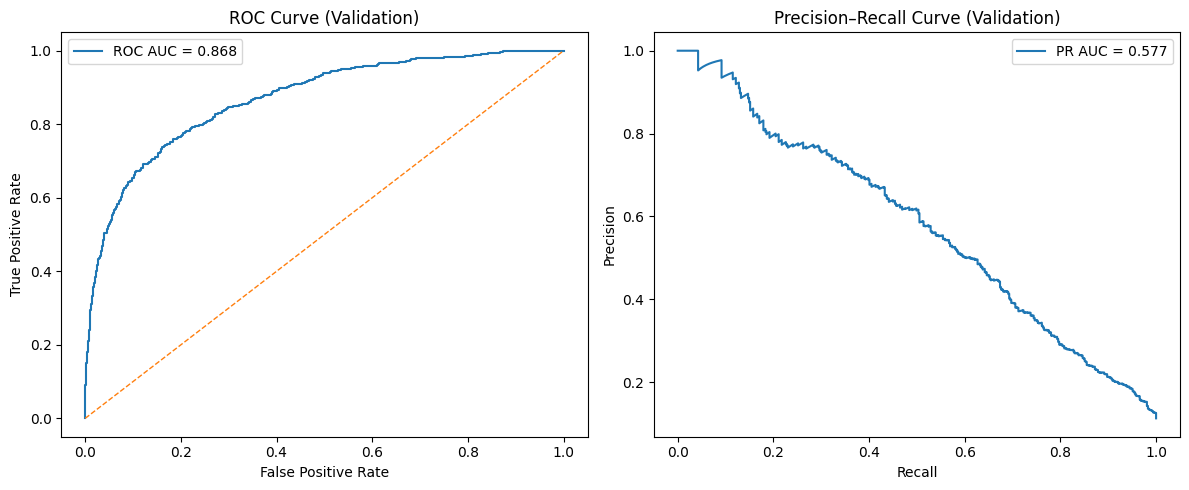

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# -----------------------------
# ROC and Precision–Recall curves for logistic regression
# -----------------------------

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_valid_proba)
roc_auc = auc(fpr, tpr)

# Precision–Recall curve
precision, recall, _ = precision_recall_curve(y_valid, y_valid_proba)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Validation)")
axes[0].legend()

# Precision–Recall
axes[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve (Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()


## 6. Tree-based baseline – Random Forest (no feature engineering)

Here we:

- Wrap the same `preprocessor` in a `RandomForestClassifier` pipeline.
- Fit on the training split.
- Evaluate on the validation split with the same metrics as logistic regression.


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# -----------------------------
# 1. Build pipeline: preprocessing + random forest
# -----------------------------

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=1,
            class_weight="balanced",  # handle class imbalance
            n_jobs=-1,
            random_state=42,
        )),
    ]
)

# -----------------------------
# 2. Fit on the training split
# -----------------------------

rf_clf.fit(X_train, y_train_split)

# -----------------------------
# 3. Predict on the validation split
# -----------------------------

y_valid_proba_rf = rf_clf.predict_proba(X_valid)[:, 1]
y_valid_pred_rf = (y_valid_proba_rf >= 0.5).astype(int)

# -----------------------------
# 4. Compute and print metrics
# -----------------------------

roc_auc_rf = roc_auc_score(y_valid, y_valid_proba_rf)
acc_rf = accuracy_score(y_valid, y_valid_pred_rf)
cm_rf = confusion_matrix(y_valid, y_valid_pred_rf)

print(f"Random Forest - Validation ROC AUC: {roc_auc_rf:.3f}")
print(f"Random Forest - Validation accuracy: {acc_rf:.3f}")
print("Random Forest - Confusion matrix (rows: true, cols: pred):")
print(cm_rf)
print("\nRandom Forest - Classification report:")
print(classification_report(y_valid, y_valid_pred_rf, digits=3))


Random Forest - Validation ROC AUC: 0.857
Random Forest - Validation accuracy: 0.893
Random Forest - Confusion matrix (rows: true, cols: pred):
[[3707    1]
 [ 444   25]]

Random Forest - Classification report:
              precision    recall  f1-score   support

           0      0.893     1.000     0.943      3708
           1      0.962     0.053     0.101       469

    accuracy                          0.893      4177
   macro avg      0.927     0.527     0.522      4177
weighted avg      0.901     0.893     0.849      4177



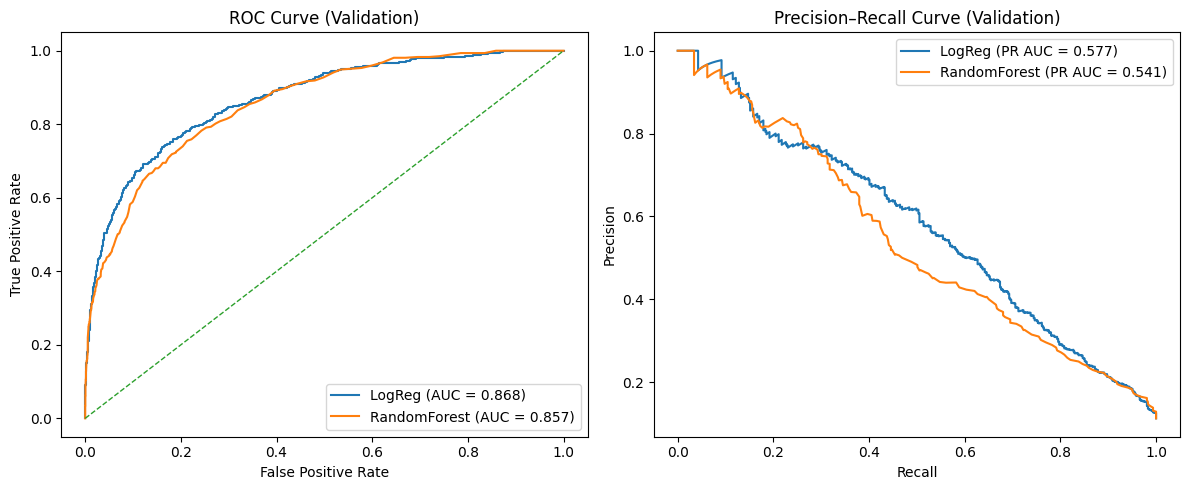

In [14]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Logistic curves (recompute to be explicit)
fpr_lr, tpr_lr, _ = roc_curve(y_valid, y_valid_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

precision_lr, recall_lr, _ = precision_recall_curve(y_valid, y_valid_proba)
pr_auc_lr = auc(recall_lr, precision_lr)

# Random Forest curves
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_valid_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

precision_rf, recall_rf, _ = precision_recall_curve(y_valid, y_valid_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_lr:.3f})")
axes[0].plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {roc_auc_rf:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Validation)")
axes[0].legend()

# PR
axes[1].plot(recall_lr, precision_lr, label=f"LogReg (PR AUC = {pr_auc_lr:.3f})")
axes[1].plot(recall_rf, precision_rf, label=f"RandomForest (PR AUC = {pr_auc_rf:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve (Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Hyperparameter tuning – Logistic Regression (v2 features)

We now fix the feature set (including the engineered numeric features)
and tune the Logistic Regression model using cross-validation.

- We use `StratifiedKFold` with 5 folds on the *training* split only.
- The tuning is done on the full pipeline (preprocessing + model),
  to avoid any data leakage.
- We optimize ROC AUC (`scoring="roc_auc"`).


In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1. Base pipeline: preprocess + logistic regression
# -----------------------------

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
        )),
    ]
)

# -----------------------------
# 2. Hyperparameter grid
# -----------------------------

param_grid_log_reg = {
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__class_weight": [None, "balanced"],
}

# -----------------------------
# 3. Cross-validation scheme
# -----------------------------

cv_scheme = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

# -----------------------------
# 4. Grid search
# -----------------------------

log_reg_grid = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid_log_reg,
    scoring="roc_auc",
    cv=cv_scheme,
    n_jobs=-1,
    verbose=1,
)

log_reg_grid.fit(X_train, y_train_split)

print("Best params:", log_reg_grid.best_params_)
print(f"Best CV ROC AUC: {log_reg_grid.best_score_:.3f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'model__C': 10, 'model__class_weight': None}
Best CV ROC AUC: 0.850


Tuned LogReg - Validation ROC AUC: 0.869
Tuned LogReg - Validation accuracy: 0.915
Tuned LogReg - Confusion matrix (rows: true, cols: pred):
[[3663   45]
 [ 311  158]]

Tuned LogReg - Classification report:
              precision    recall  f1-score   support

           0      0.922     0.988     0.954      3708
           1      0.778     0.337     0.470       469

    accuracy                          0.915      4177
   macro avg      0.850     0.662     0.712      4177
weighted avg      0.906     0.915     0.899      4177



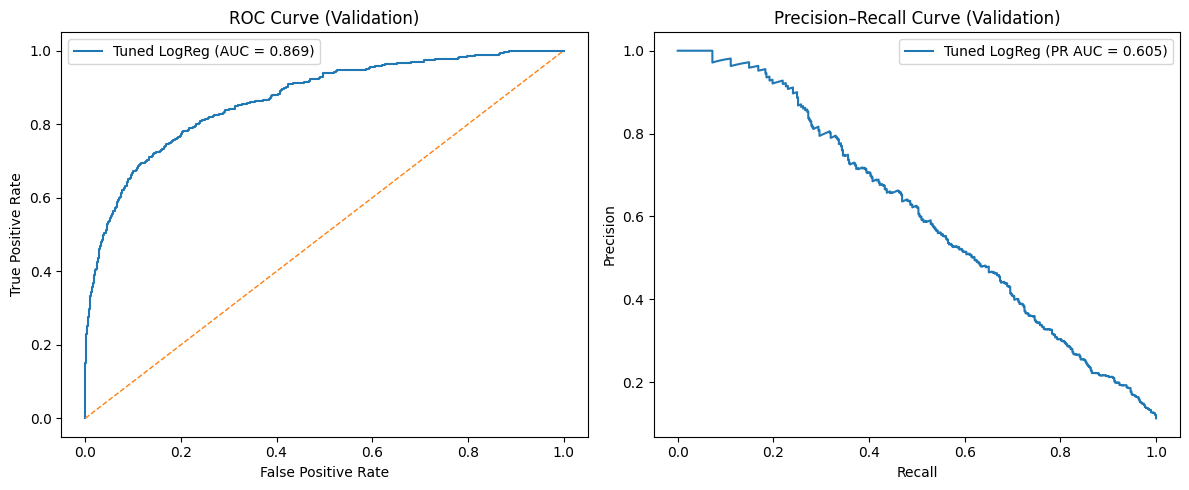

In [16]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc,
)
import matplotlib.pyplot as plt

# -----------------------------
# 1. Best tuned pipeline
# -----------------------------

best_log_reg_clf = log_reg_grid.best_estimator_

# -----------------------------
# 2. Predictions on the validation set
# -----------------------------

y_valid_proba_lr_tuned = best_log_reg_clf.predict_proba(X_valid)[:, 1]
y_valid_pred_lr_tuned = (y_valid_proba_lr_tuned >= 0.5).astype(int)

# -----------------------------
# 3. Scalar metrics
# -----------------------------

roc_auc_lr_tuned = roc_auc_score(y_valid, y_valid_proba_lr_tuned)
acc_lr_tuned = accuracy_score(y_valid, y_valid_pred_lr_tuned)
cm_lr_tuned = confusion_matrix(y_valid, y_valid_pred_lr_tuned)

print(f"Tuned LogReg - Validation ROC AUC: {roc_auc_lr_tuned:.3f}")
print(f"Tuned LogReg - Validation accuracy: {acc_lr_tuned:.3f}")
print("Tuned LogReg - Confusion matrix (rows: true, cols: pred):")
print(cm_lr_tuned)
print("\nTuned LogReg - Classification report:")
print(classification_report(y_valid, y_valid_pred_lr_tuned, digits=3))

# -----------------------------
# 4. ROC & PR curves
# -----------------------------

# ROC
fpr_lr_tuned, tpr_lr_tuned, _ = roc_curve(y_valid, y_valid_proba_lr_tuned)
roc_auc_lr_tuned_curve = auc(fpr_lr_tuned, tpr_lr_tuned)

# PR
precision_lr_tuned, recall_lr_tuned, _ = precision_recall_curve(
    y_valid, y_valid_proba_lr_tuned
)
pr_auc_lr_tuned = auc(recall_lr_tuned, precision_lr_tuned)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC plot
axes[0].plot(fpr_lr_tuned, tpr_lr_tuned,
             label=f"Tuned LogReg (AUC = {roc_auc_lr_tuned_curve:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Validation)")
axes[0].legend()

# PR plot
axes[1].plot(recall_lr_tuned, precision_lr_tuned,
             label=f"Tuned LogReg (PR AUC = {pr_auc_lr_tuned:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve (Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Use the tuned probabilities on the validation set
probs = y_valid_proba_lr_tuned

# Get precision–recall pairs for all possible thresholds
precision, recall, thresholds = precision_recall_curve(y_valid, probs)

# Avoid the last point where threshold is undefined
thresholds = thresholds

# Compute F1 for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

# Find threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_prec = precision[best_idx]
best_rec = recall[best_idx]

print(f"Best threshold by F1: {best_thresh:.3f}")
print(f"At this threshold -> precision: {best_prec:.3f}, recall: {best_rec:.3f}, F1: {best_f1:.3f}")


Best threshold by F1: 0.224
At this threshold -> precision: 0.590, recall: 0.529, F1: 0.558


In [18]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
)

# -----------------------------
# Predictions at default threshold 0.5
# -----------------------------
y_pred_05 = (y_valid_proba_lr_tuned >= 0.5).astype(int)

print("=== Threshold = 0.5 ===")
print("Accuracy:", accuracy_score(y_valid, y_pred_05))
print("Confusion matrix (rows: true, cols: pred):")
print(confusion_matrix(y_valid, y_pred_05))
print("\nClassification report:")
print(classification_report(y_valid, y_pred_05, digits=3))

# -----------------------------
# Predictions at best F1 threshold
# -----------------------------
y_pred_best = (y_valid_proba_lr_tuned >= best_thresh).astype(int)

print("\n\n=== Threshold = {:.3f} (best F1) ===".format(best_thresh))
print("Accuracy:", accuracy_score(y_valid, y_pred_best))
print("Confusion matrix (rows: true, cols: pred):")
print(confusion_matrix(y_valid, y_pred_best))
print("\nClassification report:")
print(classification_report(y_valid, y_pred_best, digits=3))


=== Threshold = 0.5 ===
Accuracy: 0.9147713670098157
Confusion matrix (rows: true, cols: pred):
[[3663   45]
 [ 311  158]]

Classification report:
              precision    recall  f1-score   support

           0      0.922     0.988     0.954      3708
           1      0.778     0.337     0.470       469

    accuracy                          0.915      4177
   macro avg      0.850     0.662     0.712      4177
weighted avg      0.906     0.915     0.899      4177



=== Threshold = 0.224 (best F1) ===
Accuracy: 0.9059133349293752
Confusion matrix (rows: true, cols: pred):
[[3536  172]
 [ 221  248]]

Classification report:
              precision    recall  f1-score   support

           0      0.941     0.954     0.947      3708
           1      0.590     0.529     0.558       469

    accuracy                          0.906      4177
   macro avg      0.766     0.741     0.753      4177
weighted avg      0.902     0.906     0.904      4177



## 8. Hyperparameter tuning – Random Forest (v2 features)

We now tune a Random Forest classifier on the same engineered feature
set, using the same cross-validation scheme as for logistic regression.

- Full pipeline: preprocessing + RandomForestClassifier
- Stratified 5-fold CV on the training split
- Optimize ROC AUC (`scoring="roc_auc"`)


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# -----------------------------
# 1. Base pipeline: preprocess + random forest
# -----------------------------

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

# -----------------------------
# 2. MUCH smaller hyperparameter grid (exploratory)
#    -> 2 x 2 x 2 = 8 combos instead of 108
# -----------------------------

param_grid_rf = {
    "model__n_estimators": [200, 400],   # fewer options
    "model__max_depth": [None, 10],      # shallow vs full-depth
    "model__min_samples_leaf": [1, 2],   # light regularization
    # Fix these for now to avoid combinatorial explosion
    "model__max_features": ["sqrt"],
    "model__class_weight": ["balanced"],
}

# -----------------------------
# 3. Faster CV scheme
#    Use 3-fold instead of 5-fold
# -----------------------------

cv_scheme_rf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42,
)

# -----------------------------
# 4. Grid search (fast version)
#    8 combos * 3 folds = 24 fits total
# -----------------------------

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv_scheme_rf,
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train_split)

print("Best RF params:", rf_grid.best_params_)
print(f"Best RF CV ROC AUC: {rf_grid.best_score_:.3f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 400}
Best RF CV ROC AUC: 0.834


Tuned RF   - Validation ROC AUC: 0.857
Tuned RF   - Validation accuracy: 0.893
Tuned RF   - Confusion matrix (rows: true, cols: pred):
[[3707    1]
 [ 444   25]]

Tuned RF   - Classification report:
              precision    recall  f1-score   support

           0      0.893     1.000     0.943      3708
           1      0.962     0.053     0.101       469

    accuracy                          0.893      4177
   macro avg      0.927     0.527     0.522      4177
weighted avg      0.901     0.893     0.849      4177



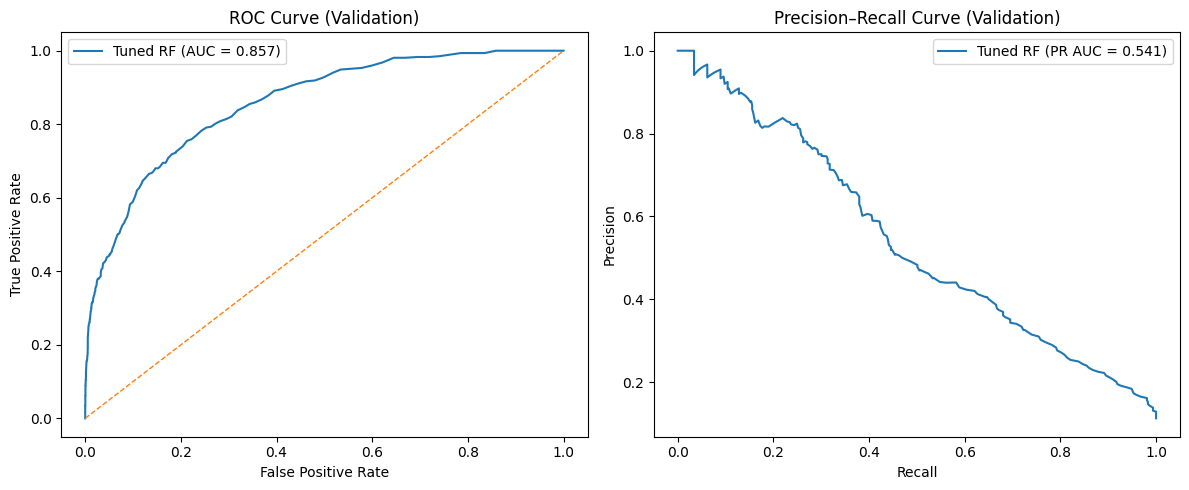

In [20]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc,
)
import matplotlib.pyplot as plt

# -----------------------------
# 1. Best tuned RF pipeline
# -----------------------------

best_rf_clf = rf_grid.best_estimator_

# -----------------------------
# 2. Predictions on the validation set
# -----------------------------

y_valid_proba_rf_tuned = best_rf_clf.predict_proba(X_valid)[:, 1]
y_valid_pred_rf_tuned = (y_valid_proba_rf_tuned >= 0.5).astype(int)

# -----------------------------
# 3. Scalar metrics
# -----------------------------

roc_auc_rf_tuned = roc_auc_score(y_valid, y_valid_proba_rf_tuned)
acc_rf_tuned = accuracy_score(y_valid, y_valid_pred_rf_tuned)
cm_rf_tuned = confusion_matrix(y_valid, y_valid_pred_rf_tuned)

print(f"Tuned RF   - Validation ROC AUC: {roc_auc_rf_tuned:.3f}")
print(f"Tuned RF   - Validation accuracy: {acc_rf_tuned:.3f}")
print("Tuned RF   - Confusion matrix (rows: true, cols: pred):")
print(cm_rf_tuned)
print("\nTuned RF   - Classification report:")
print(classification_report(y_valid, y_valid_pred_rf_tuned, digits=3))

# -----------------------------
# 4. ROC & PR curves
# -----------------------------

# ROC
fpr_rf_tuned, tpr_rf_tuned, _ = roc_curve(y_valid, y_valid_proba_rf_tuned)
roc_auc_rf_tuned_curve = auc(fpr_rf_tuned, tpr_rf_tuned)

# PR
precision_rf_tuned, recall_rf_tuned, _ = precision_recall_curve(
    y_valid, y_valid_proba_rf_tuned
)
pr_auc_rf_tuned = auc(recall_rf_tuned, precision_rf_tuned)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr_rf_tuned, tpr_rf_tuned,
             label=f"Tuned RF (AUC = {roc_auc_rf_tuned_curve:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Validation)")
axes[0].legend()

# PR
axes[1].plot(recall_rf_tuned, precision_rf_tuned,
             label=f"Tuned RF (PR AUC = {pr_auc_rf_tuned:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve (Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()


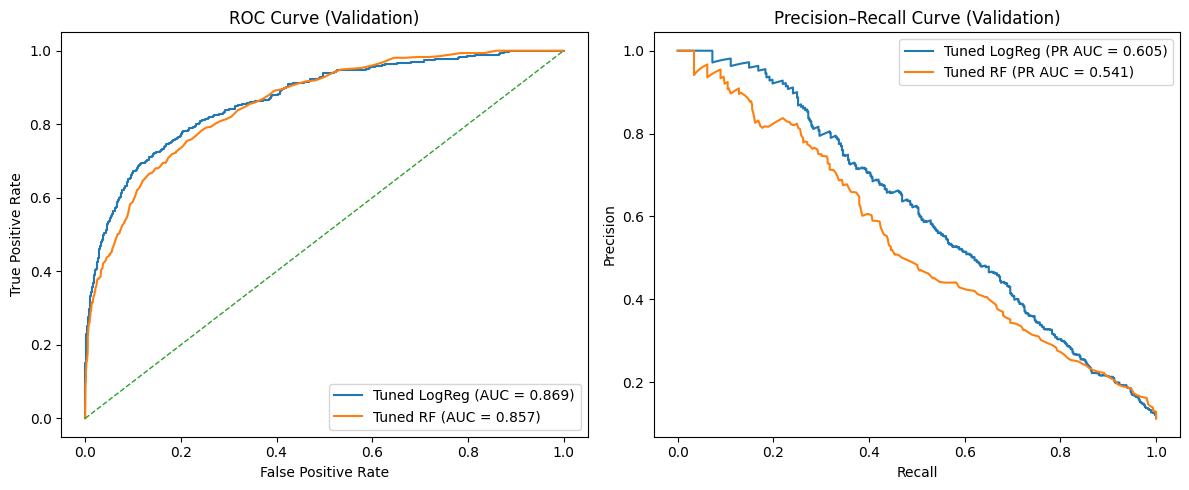

In [21]:
# Logistic curves
fpr_lr, tpr_lr, _ = roc_curve(y_valid, y_valid_proba_lr_tuned)
roc_auc_lr = auc(fpr_lr, tpr_lr)

precision_lr, recall_lr, _ = precision_recall_curve(y_valid, y_valid_proba_lr_tuned)
pr_auc_lr = auc(recall_lr, precision_lr)

# RF curves already computed above:
# fpr_rf_tuned, tpr_rf_tuned, precision_rf_tuned, recall_rf_tuned, etc.

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr_lr, tpr_lr, label=f"Tuned LogReg (AUC = {roc_auc_lr:.3f})")
axes[0].plot(fpr_rf_tuned, tpr_rf_tuned,
             label=f"Tuned RF (AUC = {roc_auc_rf_tuned_curve:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", linewidth=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve (Validation)")
axes[0].legend()

# PR
axes[1].plot(recall_lr, precision_lr,
             label=f"Tuned LogReg (PR AUC = {pr_auc_lr:.3f})")
axes[1].plot(recall_rf_tuned, precision_rf_tuned,
             label=f"Tuned RF (PR AUC = {pr_auc_rf_tuned:.3f})")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision–Recall Curve (Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()
